## Evaluation YAMNET 90-s

#### Setup

In [33]:
import os
import numpy as np
import soundfile as sf
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics

model = tf.keras.models.load_model("I:/model/vehicle/v1.1/saved_model/model.h5")
test_path = "I:/datasets/vehicle/dataset/test_set_v3/npy/"
sub_dir = os.listdir(test_path)
moving_avg = True

#### Function for moving average in waveform

In [34]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

#### Predict

In [11]:
# 1 audio predict
# audio = np.load("I:/datasets/vehicle/dataset/test_set/npy/pooks-26-may-2020_slice/2020-05-26T00-00-17/2020-05-26T00-00-17_0-2.wav.npy")
# print(audio.shape)
# print(np.expand_dims(audio, axis=0).shape)
# score = model.predict(np.expand_dims(audio, axis=0))
# print(score)

(96, 64)
(1, 96, 64)
[[0.9073905  0.09260958]]


In [35]:
y_true = []
y_pred_scores = []
count = 0

# Whole audio
for p in sub_dir:
    sub_path = test_path + p + '/'
    # Sliced audio
    for sp in os.listdir(sub_path):
        audio_data = []
        sub_path2 = sub_path + sp + '/'
        for f in os.listdir(sub_path2):
            audio = np.load(sub_path2 + f)
            audio_data.append(audio)
        
        npy_data = np.array(audio_data)
        score = model.predict(npy_data)
        target_scores = score[:,1]
        if(moving_avg):
            target_scores = moving_average(target_scores, 3)

        max_score = np.amax(target_scores)
        if(max_score > 0.99):
            count = count + 1
        if(p == 'environment'):
            y_true.append(0)
        else: 
            y_true.append(1)
        # Using max score to be each file score
        y_pred_scores.append(max_score)
    
print(count)
print("Length:", len(y_pred_scores))
print("Example:", y_pred_scores[:10])

1184
Length: 3321
Example: [0.3220978019138177, 0.004287473120105763, 0.164310143639644, 0.05997376795858145, 0.027974898771693308, 0.017285838645572465, 0.011561375111341476, 0.00018197887416511924, 0.04391841683536768, 0.4699403742949168]


In [36]:
np.save("yamnetv1.1_testv3_pred_scores.npy", y_pred_scores)
np.save("yamnetv1.1_testv3_true.npy", y_pred_scores)
# y_pred_scores = np.load("yamnet_pred_scores.npy")
# y_true = np.load("warsi_true.npy")

#### AUC

In [37]:
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred_scores)
auc_value = metrics.auc(fpr, tpr)
print(f"AUC: {auc_value}")
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
best_threshold = thresholds[ix]
print(f"Best Threshold={best_threshold}, G-Mean={gmeans[ix]}")

AUC: 0.9842299597198533
Best Threshold=0.6465172364066044, G-Mean=0.946993761340897


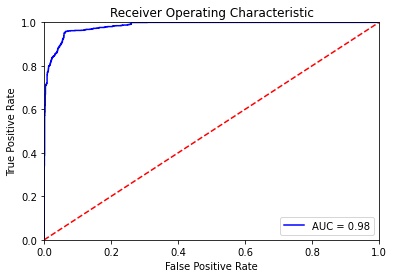

In [38]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc_value)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('yamnetv1.1_testv3_auc.png')
plt.show()

#### Precision and recall

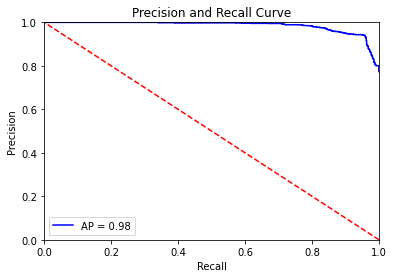

In [39]:
avg_precision_score = metrics.average_precision_score(y_true, y_pred_scores)

precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_pred_scores)

plt.title('Precision and Recall Curve')
plt.plot(recall, precision, 'b', label = 'AP = %0.2f' % avg_precision_score)
plt.legend(loc = 'lower left')
plt.plot([1, 0], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.savefig('yamnetv1.1_testv3_prec.png')
plt.show()

#### Calcurate confusion metrix

In [40]:
y_pred = []

for y in y_pred_scores:
    if (y < best_threshold):
        y_pred.append(0)
    else:
        y_pred.append(1)
        
cfmx = metrics.confusion_matrix(y_true, y_pred)
print("Confusion matrix:")
print(cfmx)

tn, fp, fn, tp = cfmx.ravel()
print(f"true positive: {tp}, true negative: {tn}, false positive: {fp}, false negative: {fn}")

Confusion matrix:
[[1518  103]
 [  72 1628]]
true positive: 1628, true negative: 1518, false positive: 103, false negative: 72


In [41]:
report = metrics.classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1621
           1       0.94      0.96      0.95      1700

    accuracy                           0.95      3321
   macro avg       0.95      0.95      0.95      3321
weighted avg       0.95      0.95      0.95      3321

